# Homework 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pickle

import hw2_utils as u

from tqdm.auto import tqdm

In [2]:
# Load the Problem set 2 data
with open("hw2_data.pkl", "rb") as f:
    data = pickle.load(f).T

t_i = data[0]
sigma_i = data[1]
y_i = data[-1]

datasets = data[2:]

data = (t_i, y_i, sigma_i)  # For quick usage in problems that require the last dataset

# Problem 1

Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2 and sample in the 6-dimensional space (5 linear amplitudes and the period T) with some sensible priors on all 6 parameters (we’ll discuss possible priors in class). Make a "corner plot" of the posterior sampling, and plot a sampling of 16 independent samples from the posterior in the space of the data, on the data.

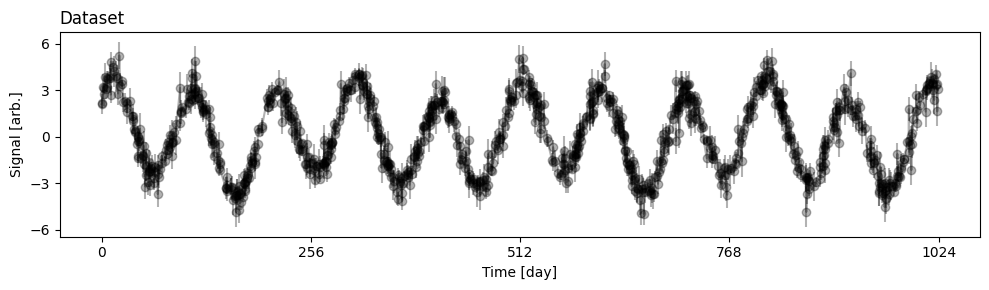

In [3]:
plt.figure(figsize=(10, 3))
plt.errorbar(t_i, y_i, yerr=sigma_i, color="k", marker="o", alpha=0.3, zorder=0)
plt.title("Dataset", loc='left')
plt.xlabel("Time [day]")
plt.ylabel("Signal [arb.]")
plt.xticks([0, 256, 512, 768, 1024])
plt.yticks([-6, -3, 0, 3, 6])
plt.tight_layout()
plt.show()

In [4]:
# Period search limits (from HW2)
min_T = 1 / (0.5 * np.median(1 / np.diff(t_i)))
max_T = 2048

def model(parameters, t_i):
    D, A1, A2, A3, A4, T_1 = parameters[:6]
    T_0 = 100
    sine_1 = A1 * np.sin(2 * np.pi * t_i / T_0) + A2 * np.cos(2 * np.pi * t_i / T_0)
    sine_2 = A3 * np.sin(2 * np.pi * t_i / T_1) + A4 * np.cos(2 * np.pi * t_i / T_1)
    return D + sine_1 + sine_2

def log_prior(parameters):
    from scipy.stats import uniform
    
    D, A1, A2, A3, A4, T_1 = parameters[:6]
    
    output = 0
    
    # DC level: U(0, 0.1)
    output += uniform.logpdf(D, loc=0, scale=0.5)
    
    # Signal 1 amplitudes: U(-6, 6)
    output += uniform.logpdf(A1, loc=-6, scale=12)
    output += uniform.logpdf(A2, loc=-6, scale=12)
    
    # Signal 2 amplitudes: U(-6, 6)
    output += uniform.logpdf(A3, loc=-6, scale=12)
    output += uniform.logpdf(A4, loc=-6, scale=12)
    
    # Period: 1/T (normalized to integrate to 1 over the range)
    output += np.log((1 / T_1) / (np.log(max_T) - np.log(min_T))) if T_1 > min_T and T_1 < max_T else float("-inf")
    
    return output
    

def log_prob(parameters):
    """returns the log of the product of the prior and the likelihood (e.g. logprior + logl)"""
    return u.logl(parameters, model, data) + log_prior(parameters)
    

rng = np.random.default_rng()

nwalkers = 32

# Randomly generate initial guesses: choose from narrow-ish
# Gaussians (std = 10% of mean) about best-fits
bestfit = np.array([0.072, 2.29, 1.97, 0.616, 0.556, 256.7])  # from HW2
p0 = np.zeros((nwalkers, 6))
for i in range(6):
    p0[:, i] = rng.normal(loc=bestfit[i], scale=bestfit[i] * 0.1, size=nwalkers)


# Sample
sampler = emcee.EnsembleSampler(nwalkers, 6, log_prob)
state = sampler.run_mcmc(p0, 1_000, progress=True)  # burn-in
sampler.reset()
sampler.run_mcmc(state, 20_000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:01<00:00, 110.25it/s]


Mean acceptance fraction: 0.485
Mean autocorrelation time: 88.871 steps


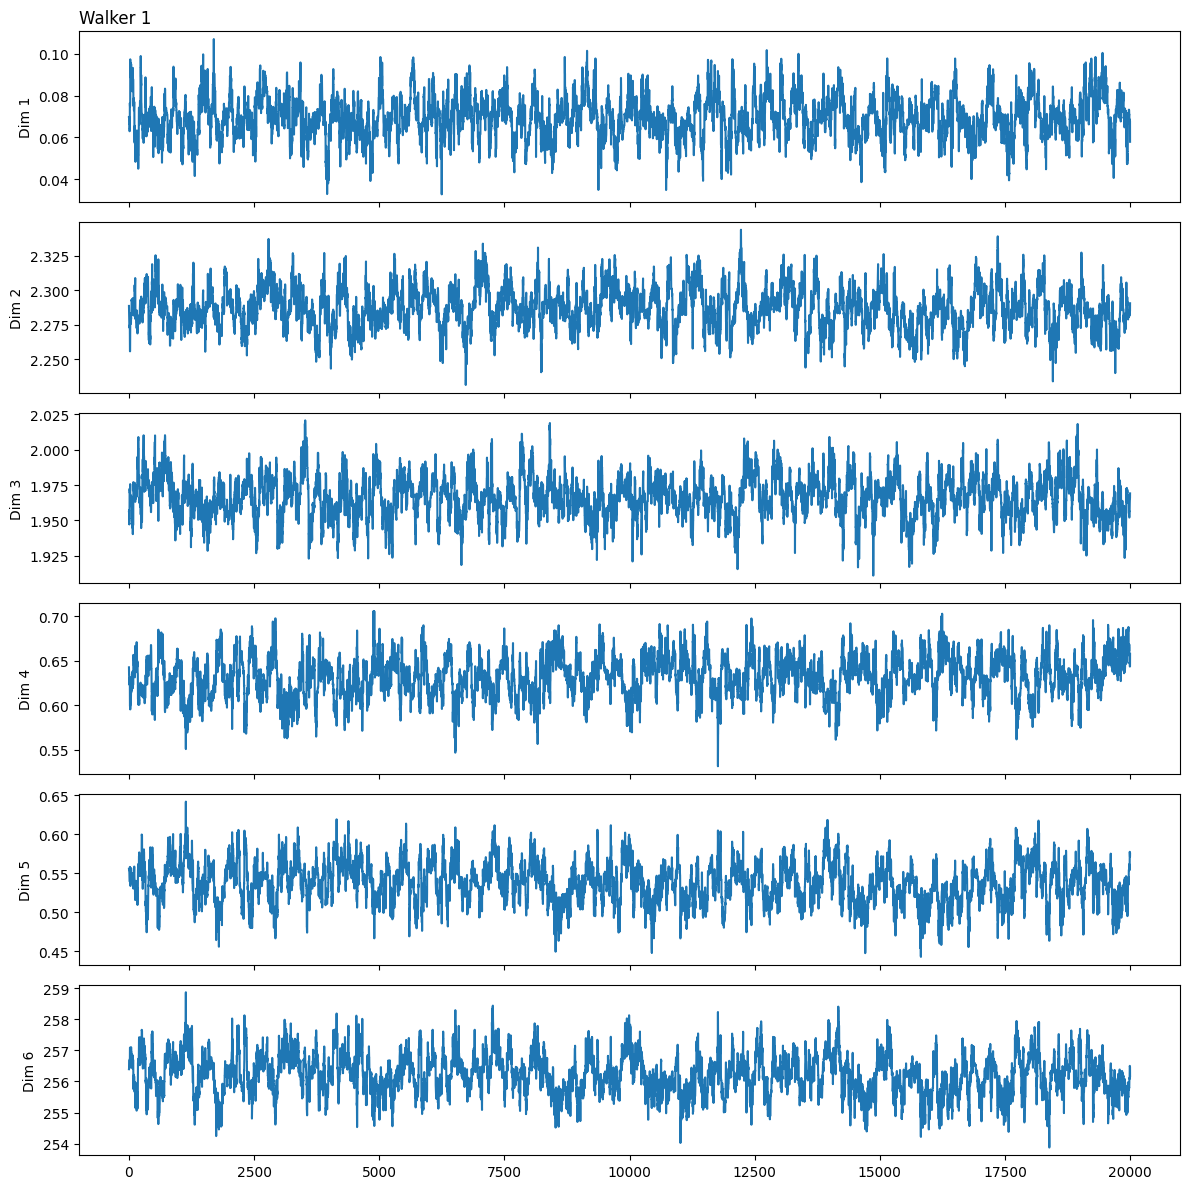

In [5]:
# Simple convergence checks
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time: {np.mean(sampler.get_autocorr_time(quiet=True)):.3f} steps")

chain = sampler.get_chain()[:, 0, :]
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)
for i, ax in enumerate(axs.flat):
    ax.plot(chain[:, i])
    ax.set_ylabel(f'Dim {i+1}')
axs[0].set_title('Walker 1', loc='left')
fig.tight_layout()
plt.show()

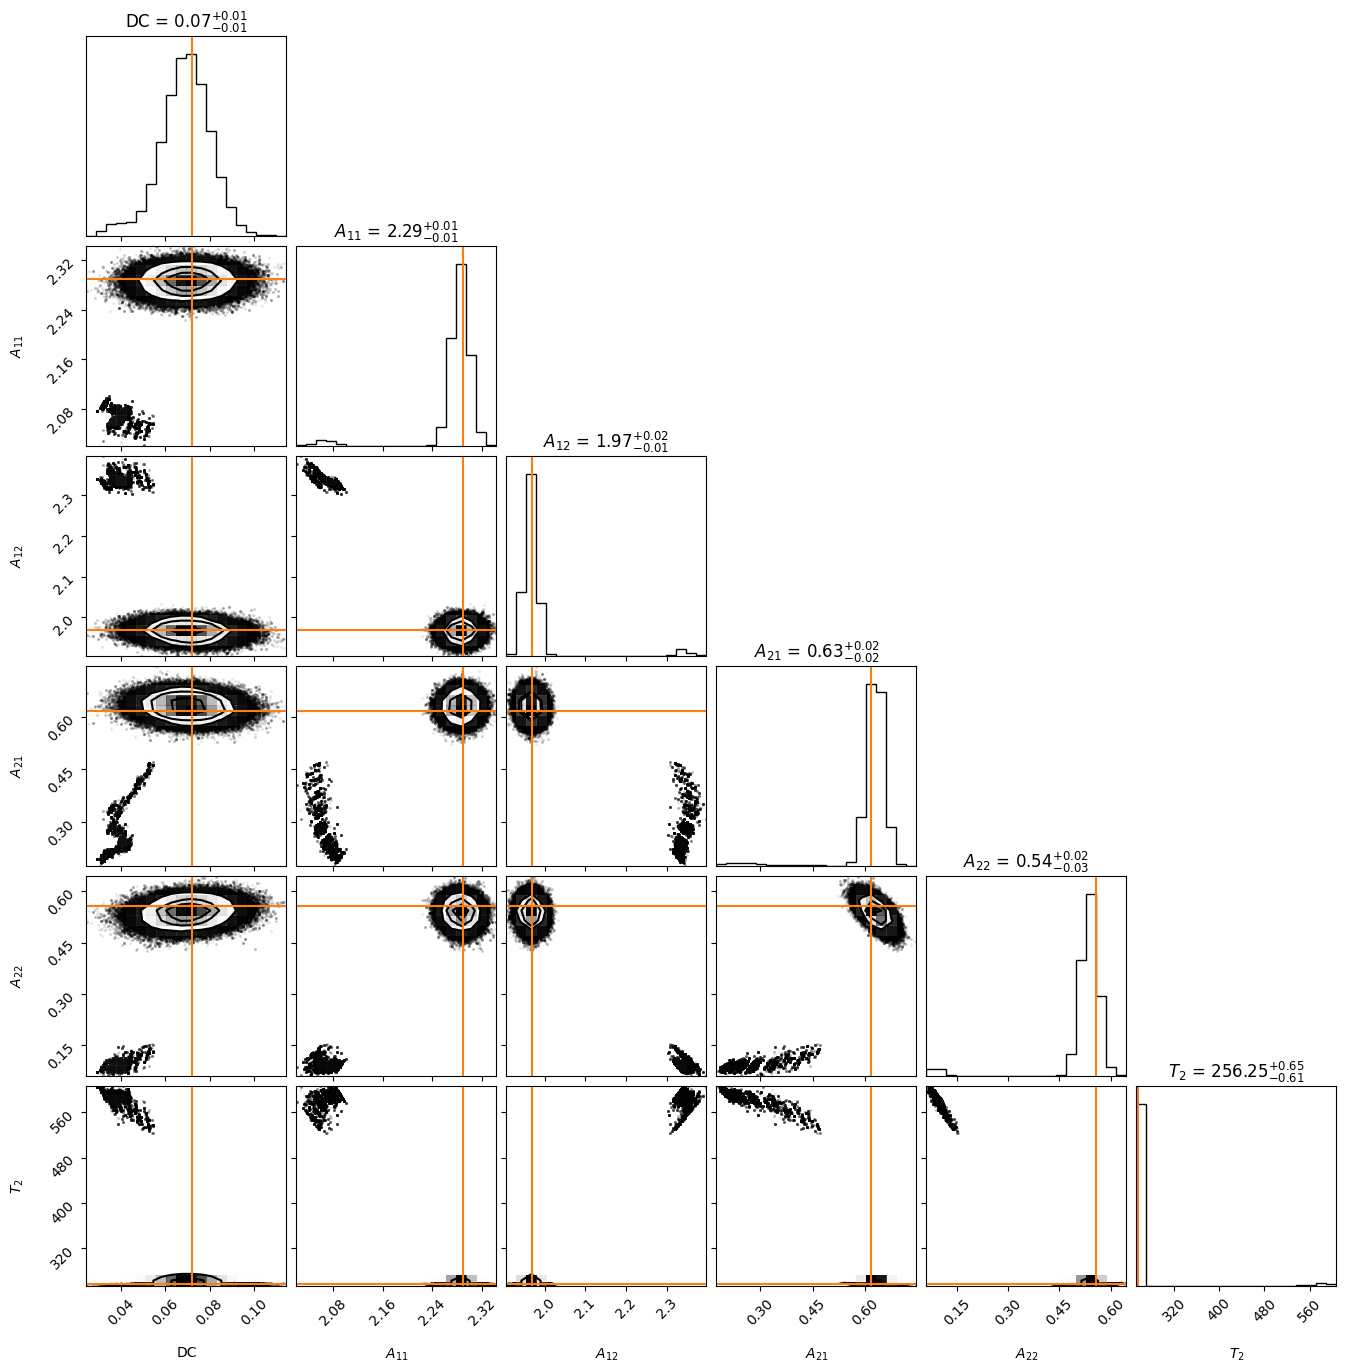

In [6]:
# Corner plot
samples = sampler.get_chain(flat=True)
fig = corner.corner(
    samples,
    labels=[
        'DC',
        '$A_{11}$',
        '$A_{12}$',
        '$A_{21}$',
        '$A_{22}$',
        '$T_2$'
    ],
    show_titles=True
)

corner.overplot_lines(fig, bestfit, color="C1")

Old best-fit parameters: logl = -467.00
Mean sampled parameters: logl = -1028.51


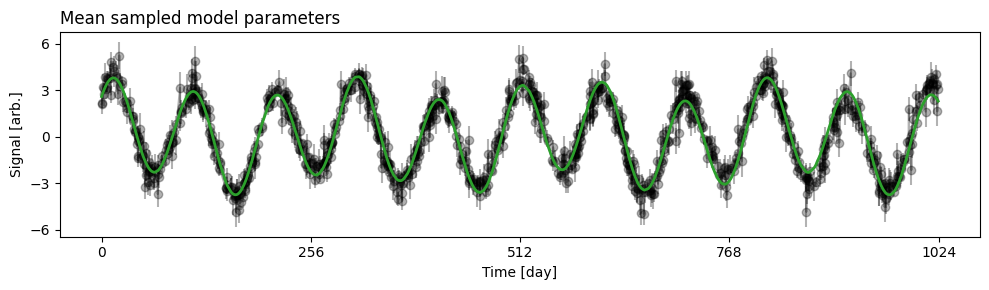

In [7]:
print(f"Old best-fit parameters: logl = {u.logl(bestfit, model, data):.2f}")
print(f"Mean sampled parameters: logl = {u.logl(np.mean(samples, axis=0), model, data):.2f}")

plt.figure(figsize=(10, 3))
plt.errorbar(t_i, y_i, yerr=sigma_i, color="k", marker="o", alpha=0.3, zorder=0)
plt.plot(t_i, model(np.mean(samples, axis=0), t_i), color="C2", lw=2, alpha=1, zorder=1)
plt.title("Mean sampled model parameters", loc='left')
plt.xlabel("Time [day]")
plt.ylabel("Signal [arb.]")
plt.xticks([0, 256, 512, 768, 1024])
plt.yticks([-6, -3, 0, 3, 6])
plt.tight_layout()
plt.show()

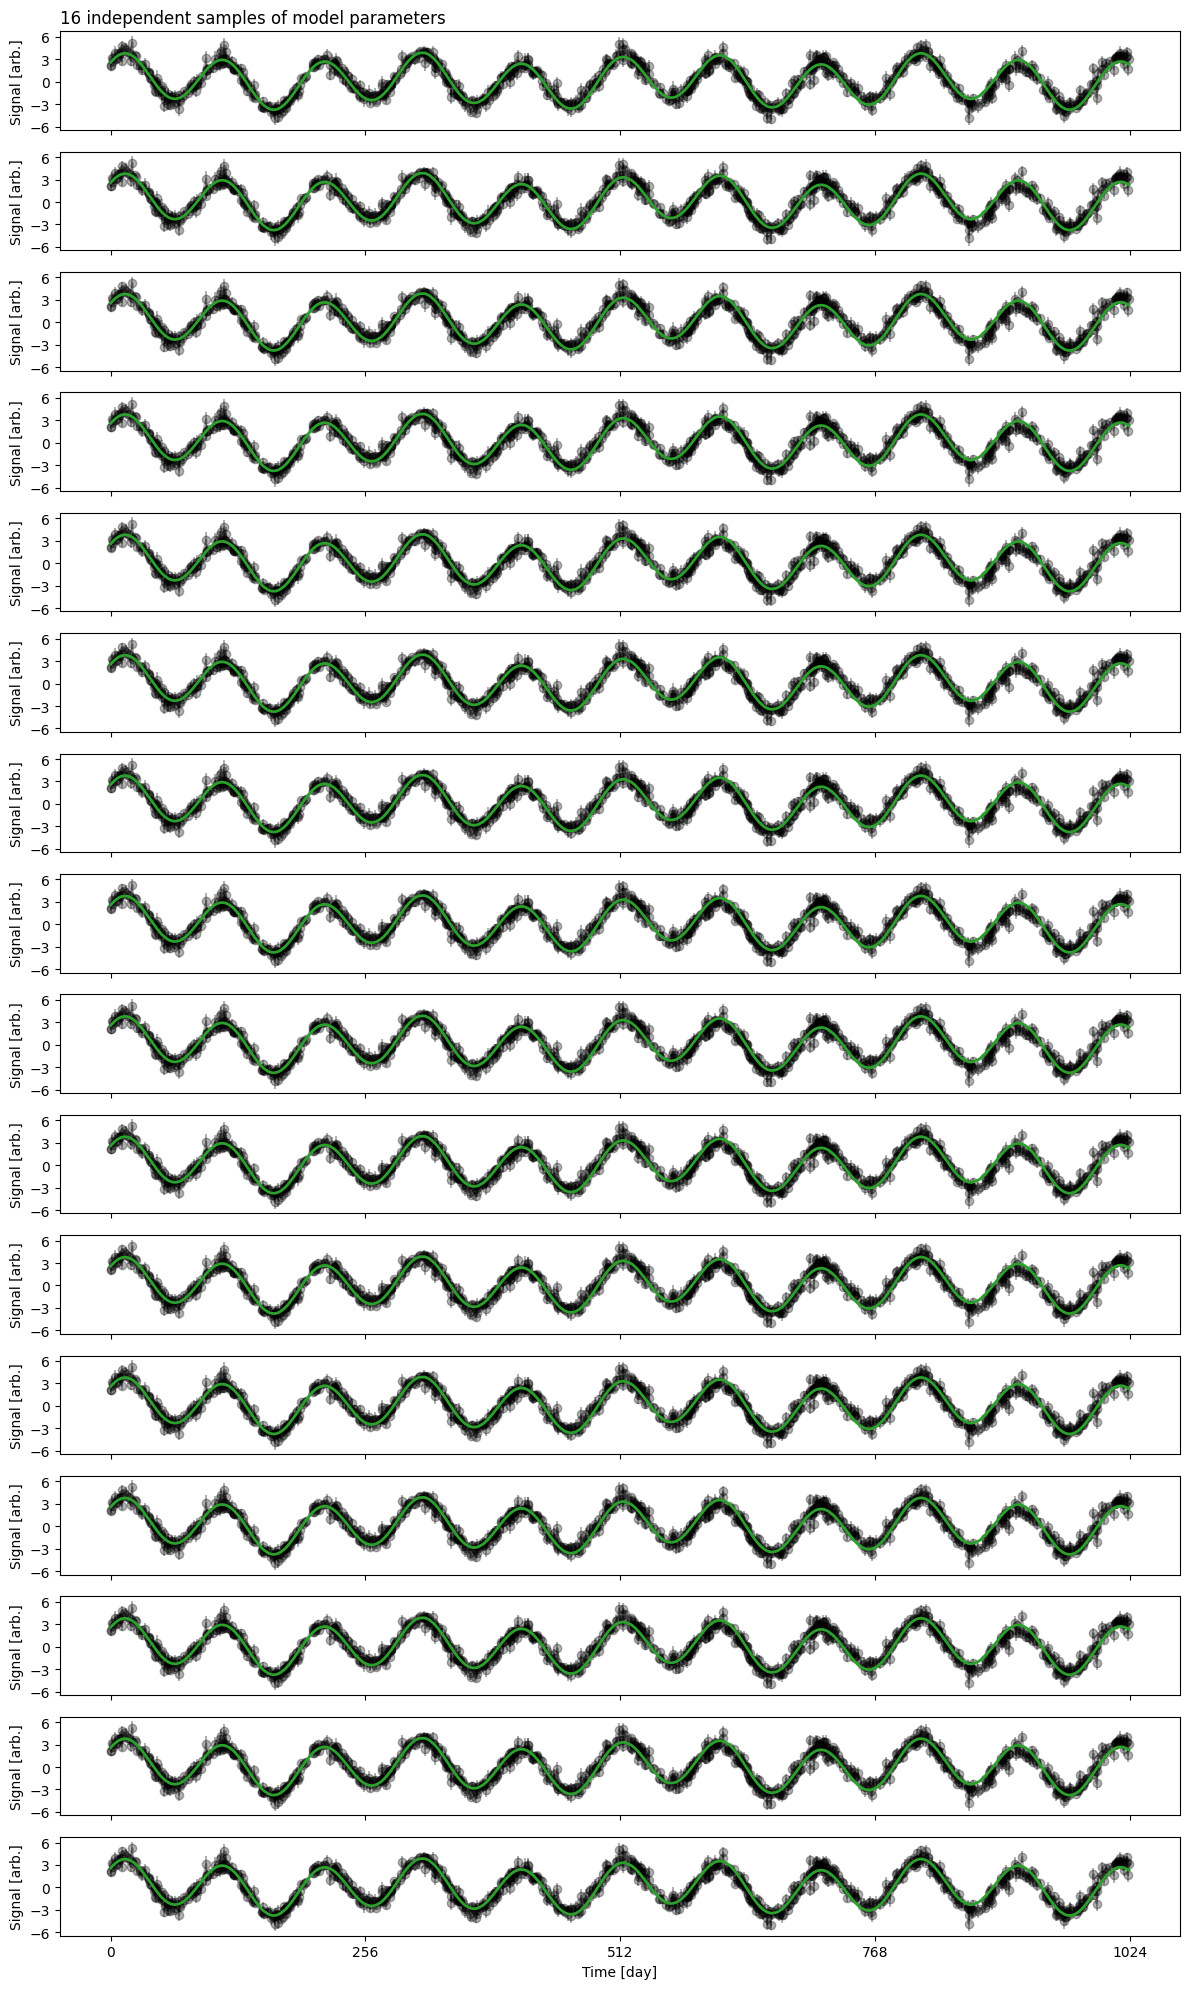

In [8]:
# 16 independent points (of at least <autocorrelation time> apart)
samples = sampler.get_chain(thin=2 * int(sampler.get_autocorr_time().max()), flat=True)
indep_sample_idx = rng.choice(len(samples), 16)
indep_samples = samples[indep_sample_idx]

fig, axs = plt.subplots(16, 1, figsize=(12, 20), sharex=True)
for ax, sample in zip(axs.flat, indep_samples):
    ax.errorbar(t_i, y_i, yerr=sigma_i, color="k", marker="o", alpha=0.3, zorder=0)
    ax.plot(t_i, model(np.mean(samples, axis=0), t_i), color="C2", lw=2, alpha=1, zorder=1)
    ax.set_ylabel("Signal [arb.]")
    ax.set_xticks([0, 256, 512, 768, 1024])
    ax.set_yticks([-6, -3, 0, 3, 6])
axs[0].set_title("16 independent samples of model parameters", loc='left')
axs[-1].set_xlabel("Time [day]")
fig.tight_layout()
plt.show()

# Problem 2

Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2, and plot the residuals (data minus best-fit model expectation) away from the one-period (100-day-period) model, but folded at the period of the putative best-fit period T. Is it believable? That is, check the model, visually.

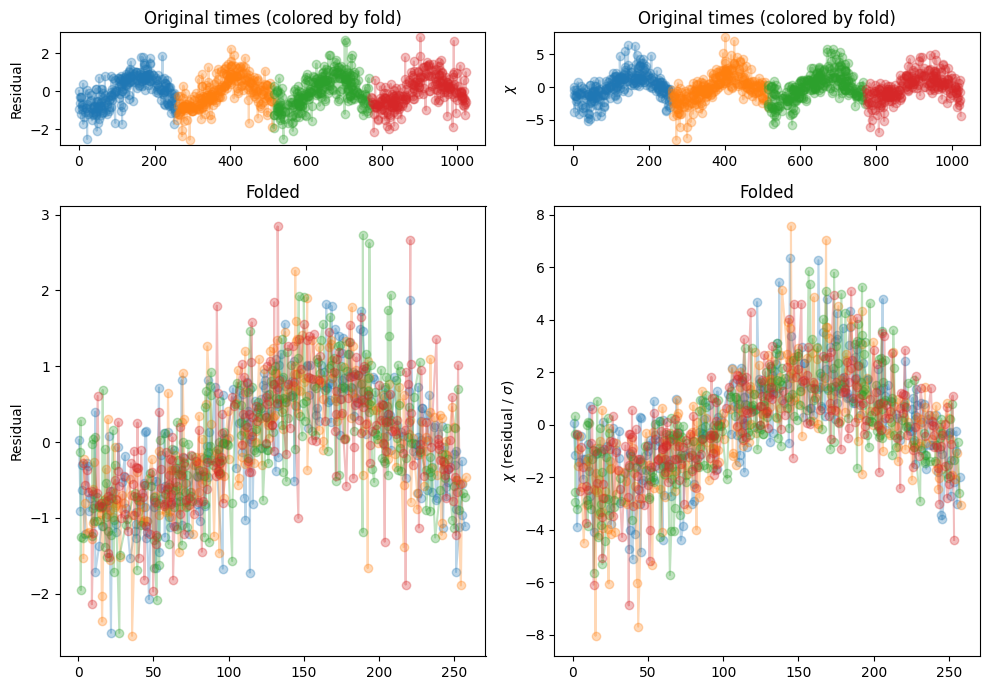

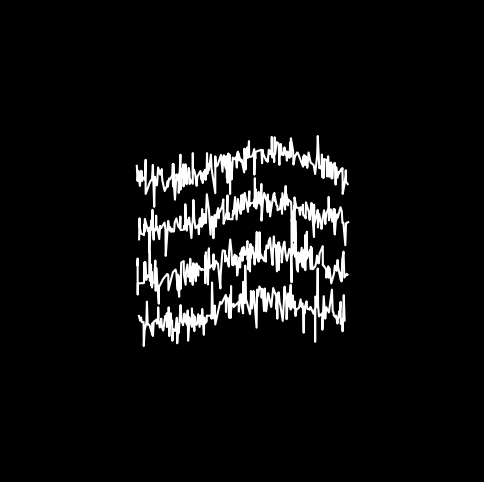

In [9]:
# Compute the best fit with one signal
fit, logl = u.max_likelihood_estimate(u.one_signal_model, [0, 1, 1], data)

# Compute the residuals
residue = u.one_signal_model(fit, t_i) - y_i
chi = residue / sigma_i

# Define the best-fit second period
T_1 = bestfit[-1]
    
fig, axs = plt.subplots(2, 2, figsize=(10, 7), gridspec_kw=dict(height_ratios=[1, 4]))
for i in range(int(1024 // T_1) + 1):
    lo = np.searchsorted(t_i, T_1 * i, side='right') + 1
    hi = np.searchsorted(t_i, T_1 * (i + 1), side='right') + 1
    axs[0, 0].plot(t_i[lo:hi], residue[lo:hi], alpha=0.3, marker='o', zorder=0)
    axs[1, 0].plot(t_i[lo:hi] - (T_1 * i), residue[lo:hi], alpha=0.3, marker='o', zorder=0)
    
    axs[0, 1].plot(t_i[lo:hi], chi[lo:hi], alpha=0.3, marker='o', zorder=0)
    axs[1, 1].plot(t_i[lo:hi] - (T_1 * i), chi[lo:hi], alpha=0.3, marker='o', zorder=0)

axs[0, 0].set_title('Original times (colored by fold)')
axs[1, 0].set_title('Folded')
axs[0, 0].set_ylabel('Residual')
axs[1, 0].set_ylabel('Residual')
    
axs[0, 1].set_title('Original times (colored by fold)')
axs[1, 1].set_title('Folded')
axs[0, 1].set_ylabel('$\chi$')
axs[1, 1].set_ylabel('$\chi$ (residual / $\sigma$)')
fig.tight_layout()
plt.show()

# Joy Division plot
plt.style.use('dark_background')
plt.figure(figsize=(6, 6))

n_folds = int(1024 // T_1) + 1
gap = 3

for index, i in enumerate(range(n_folds)):
    lo = np.searchsorted(t_i, T_1 * i, side='right') + 1
    hi = np.searchsorted(t_i, T_1 * (i + 1), side='right') + 1
    plt.plot(t_i[lo:hi] - (T_1 * i), residue[lo:hi] - (gap * i), color='w')
    plt.fill_between(t_i[lo:hi] - (T_1 * i), -gap * i, residue[lo:hi] - (gap * i), color='k')
    
plt.axis('off')
plt.margins(0.6)
plt.show()

plt.style.use('default')

Could be cool if we had a more highly peaked, lower period signal

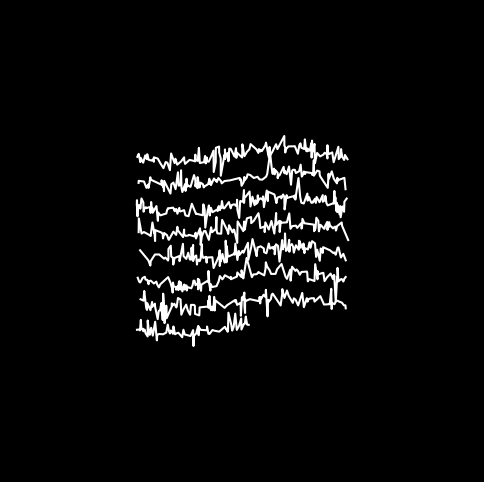

In [10]:
_data = (t_i, datasets[6], sigma_i)

# Compute the best fit with one signal
fit, logl = u.max_likelihood_estimate(u.one_signal_model, [0, 1, 1], _data)

# Compute the residuals
residue = u.one_signal_model(fit, t_i) - _data[1]
chi = residue / _data[2]

# Define the best-fit second period
T_1 = 135.8

# Joy Division plot
plt.style.use('dark_background')
plt.figure(figsize=(6, 6))

n_folds = int(1024 // T_1) + 1
gap = 3

for index, i in enumerate(range(n_folds)):
    lo = np.searchsorted(t_i, T_1 * i, side='right') + 1
    hi = np.searchsorted(t_i, T_1 * (i + 1), side='right') + 1
    plt.plot(t_i[lo:hi] - (T_1 * i), residue[lo:hi] - (gap * i), color='w')
    plt.fill_between(t_i[lo:hi] - (T_1 * i), -gap * i, residue[lo:hi] - (gap * i), color='k')
    
plt.axis('off')
plt.margins(0.6)
plt.show()

plt.style.use('default')

Meh, still no pulsar

# Problem 3

Re-do problem 2 of Problem Set 2 using K-fold cross-validation with K=8. That is, fit the 1- and 2-period models to all but one eighth of each data set and predict the held-out eighth, and repeat for all eight held-out eighths, for all 11 data sets. Which is a better model in each case? Now compute the AIC and BIC instead. Which is a better model according to these? Make a table, maybe?

In [11]:
try:
    with open("hw2_best_fits.pkl", "rb") as f:
        best_fits = pickle.load(f)
        
except:
    def compute_freq_grid(t_i):
        freqs = 1 / np.diff(t_i)
        max_f = 0.5 * np.median(freqs)  # approx Nyquist
        f_width = 1 / 2048
        freq_grid = np.arange(0, max_f + f_width/2, step=f_width)
        return freq_grid

    def parabola_vertex(x, y):
        X = np.array([[_x**2, _x, 1] for _x in x])
        y = np.reshape(y, (-1, 1))
        theta = np.linalg.solve(X, y)
        a, b, c = theta[:, 0]
        return -0.5 * b / a

    freq_grid = compute_freq_grid(t_i)
    freq_search_logls = np.zeros((len(datasets), len(freq_grid)))
    best_fits = np.zeros((len(datasets), 6))

    for i, y_i in enumerate(tqdm(datasets, desc="Finding frequencies", unit="dataset")):
        data = (t_i, y_i, sigma_i)

        for j, freq in enumerate(freq_grid):
            _, logl = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1, 1, 1], [freq], data)
            freq_search_logls[i, j] = logl

        index = np.argmax(freq_search_logls[i, :])
        coords = slice(index - 1, index + 2)
        best_freq = parabola_vertex(freq_grid[coords], freq_search_logls[i, coords])
        
        fit, _ = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1, 1, 1], [best_freq], data)
        best_fits[i, :-1] = fit
        best_fits[i, -1] = best_freq
        
    with open("hw2_best_fits.pkl", "wb") as f:
        pickle.dump(best_fits, f)

In [12]:
def k_fold(y_i, best_fit_2, k=8):
    
    def step(i):
        assert i >= 0 and i < k
        
        # split data into train, validation sets
        width = int(len(y_i) // k)
        lo = width * i
        hi = width * (i + 1)
        
        mask = np.ones(len(y_i), dtype=bool)
        mask[lo:hi] = False
        
        _data = (t_i, y_i, sigma_i)
        _data_tr = tuple(map(lambda x: x[mask], _data))  # train
        _data_va = tuple(map(lambda x: x[~mask], _data))  # validation
        
        # fit models to train set
        fit_1, logl_1 = u.max_likelihood_estimate(u.one_signal_model, [0, 1, 1], _data_tr)
        fit_2, logl_2 = u.max_likelihood_estimate(u.two_signal_model, best_fit_2, _data_tr)
        
        # evalute performance on validation set
        t_va, y_va, sigma_va = _data_va
        delta_1 = (y_va - u.one_signal_model(fit_1, t_va)) / sigma_va
        delta_2 = (y_va - u.two_signal_model(fit_2, t_va)) / sigma_va
        
        return np.sum(delta_1 ** 2), np.sum(delta_2 ** 2)

    
    deltas = np.array([ step(i) for i in range(k) ])
    chi_sq_1, chi_sq_2 = np.sum(deltas, axis=0)
    return chi_sq_1, chi_sq_2

def aic_bic(y_i, best_fit_2):
    fit_1, logl_1 = u.max_likelihood_estimate(u.one_signal_model, [0, 1, 1], (t_i, y_i, sigma_i))
    fit_2, logl_2 = u.max_likelihood_estimate(u.two_signal_model, best_fit_2, (t_i, y_i, sigma_i))
    
    def aic(k, logl):
        return 2 * k - 2 * logl
    
    def bic(k, logl, n):
        return k * np.log(n) - 2 * logl
    
    aic_1 = aic( len(fit_1), logl_1 )
    aic_2 = aic( len(fit_2), logl_2 )
    
    bic_1 = bic( len(fit_1), logl_1, len(y_i) )
    bic_2 = bic( len(fit_2), logl_2, len(y_i) )
    
    return aic_1, aic_2, bic_1, bic_2

In [13]:
fmt = " {:<12} | {:>8}{:>8} | {:>8}{:>8} | {:>8}{:>8}"
fmt_title = " {:<12} | {:<16} | {:<16} | {:<16}"

print(fmt_title.format("", "k-fold chi^2", "AIC", "BIC"))
print(fmt.format("", "1sin", "2sin", "1sin", "2sin", "1sin", "2sin"))
print("-----------------------------------------------------------------------")

for i, y_i in enumerate(datasets):
    chi_sq_1, chi_sq_2 = k_fold(y_i, best_fits[i])
    aic_1, aic_2, bic_1, bic_2 = aic_bic(y_i, best_fits[i])
    print(fmt.format(
        f"Dataset {i+1}",
        f"{chi_sq_1:.0f}",
        f"{chi_sq_2:.0f}",
        f"{aic_1:.0f}",
        f"{aic_2:.0f}",
        f"{bic_1:.0f}",
        f"{bic_2:.0f}",
    ))

              | k-fold chi^2     | AIC              | BIC             
              |     1sin    2sin |     1sin    2sin |     1sin    2sin
-----------------------------------------------------------------------
 Dataset 1    |     1013     997 |     1013    1002 |     1028    1031
 Dataset 2    |     1019    1011 |     1020    1013 |     1034    1042
 Dataset 3    |     1003     993 |     1001     995 |     1016    1024
 Dataset 4    |     1051    1043 |     1046    1035 |     1061    1065
 Dataset 5    |      978     969 |      976     969 |      991     999
 Dataset 6    |      994     990 |      994     985 |     1009    1015
 Dataset 7    |     5119    1018 |     4333    1022 |     4347    1051
 Dataset 8    |     1338    1096 |     1291    1081 |     1306    1111
 Dataset 9    |     4924    1028 |     4380    1024 |     4395    1054
 Dataset 10   |     1124    1108 |     1125    1112 |     1139    1141
 Dataset 11   |     4808     946 |     4198     945 |     4213     975


We always expect the two-signal model to perform at least marginally better (read: smaller $\chi^2$ values) than the one-signal model, since they are nested models. Even when no second signal exists, the first signal will be fit at least as well, because the second signal can be used to overfit to the data slightly. As such, looking at the $\chi^2$ values on the held-out sets from $k$-fold validation, I would say that we should only choose the two-signal model over the one-signal model when the two differ substantially. Somewhat arbitrarily, setting such a threshold to a difference of around 100 would reproduce our likelihood-ratio based results from HW2. 

The AIC and BIC metrics are supposed to correct for this issue of differing numbers of parameters somewhat, but the strength of this correction seems to be a little lacking, particularly for the AIC.

Here's a table summarizing which model had the better (lower) of each of these scores on each dataset.

| | k-fold | AIC | BIC |
| --- | --- | --- | --- |
| Dataset 1  | 2sig | 2sig | 1sig |
| Dataset 2  | 2sig | 2sig | 1sig |
| Dataset 3  | 2sig | 2sig | 1sig |
| Dataset 4  | 2sig | 2sig | 1sig |
| Dataset 5  | 2sig | 2sig | 1sig |
| Dataset 6  | 2sig | 2sig | 1sig |
| Dataset 7  | 2sig | 2sig | 2sig |
| Dataset 8  | 2sig | 2sig | 2sig |
| Dataset 9  | 2sig | 2sig | 2sig |
| Dataset 10 | 2sig | 2sig | 1sig |
| Dataset 11 | 2sig | 2sig | 2sig |

Only BIC reproduces the expected results.

# (Bonus)

Did not have time.